In [35]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if "adrian_sensorium" not in os.getcwd():
    os.chdir("adrian_sensorium")

print('Working directory:', os.getcwd())

Working directory: d:\Python\Anastasia\Petreanu Lab\adrian_sensorium


In [36]:
# %%capture
# !pip install -e ./lib/mei

In [37]:
os.getcwd()

'd:\\Python\\Anastasia\\Petreanu Lab\\adrian_sensorium'

## Restart Kernel after mei-module installation!

In [38]:
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from nnfabrik.builder import get_data, get_model
from notebooks.submission_m4.gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores

In [39]:
from sensorium.utility.training import read_config

In [40]:
seed=31415
# data_key_aut = "29027-6-17-1-6-5"
# data_key_wt = "29028-1-17-1-6-5"
# data_key_sens2 = "23964-4-22"
# autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [41]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

In [42]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE09665/2023_03_20',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_23',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_31',
 'notebooks/data/IM_prezipped/LPE10884/2023_10_12',
 'notebooks/data/IM_prezipped/LPE10885/2023_10_20',
 'notebooks/data/IM_prezipped/LPE10919/2023_11_09',
 'notebooks/data/IM_prezipped/LPE11086/2023_12_16',
 'notebooks/data/IM_prezipped/LPE11086/2024_01_09',
 'notebooks/data/IM_prezipped/LPE11495/2024_02_29',
 'notebooks/data/IM_prezipped/LPE11998/2024_05_08',
 'notebooks/data/IM_prezipped/LPE12223/2024_06_11']

In [43]:
# dataset_fn = 'sensorium.datasets.static_loaders'

# filenames_autistic = [autistic_mouse_dataPath, ]

# dataset_config_autistic = {'paths': filenames_autistic,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

# filenames_wildtype = [wildtype_mouse_dataPath, ]

# dataset_config_wildtype = {'paths': filenames_wildtype,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

# filenames_sens2 = [sens2_dataPath, ]

# dataset_config_sens2 = {'paths': filenames_sens2,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':0.25,
#                  }

# dataloaders_sens2 = get_data(dataset_fn, dataset_config_sens2)

In [44]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

In [45]:
# model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
# model_config = {'pad_input': False,
#   'stack': -1,
#   'layers': 4,
#   'input_kern': 9,
#   'gamma_input': 6.3831,
#   'gamma_readout': 0.0076,
#   'hidden_kern': 7,
#   'hidden_channels': 64,
#   'depth_separable': True,
#   'grid_mean_predictor': {'type': 'cortex',
#    'input_dimensions': 2,
#    'hidden_layers': 1,
#    'hidden_features': 30,
#    'final_tanh': True},
#   'init_sigma': 0.1,
#   'init_mu_range': 0.3,
#   'gauss_type': 'full',
#   'shifter': False,
# }

# model_a = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_autistic,
#                   seed=seed,
#                   )
# model_wt = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_wildtype,
#                   seed=seed,
#                   )

# model_sens2= get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_sens2,
#                   seed=seed,
#                   )

In [46]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
# model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
# model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
# model_sens2.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

In [48]:
# model_a.eval()
# model_wt.eval()
# model_sens2.eval()

In [49]:
# correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
# correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
# correlation_to_average_s2 = get_signal_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)

# df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
# df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
# df_cta_s2 = get_df_for_scores(session_dict=correlation_to_average_s2, measure_attribute="Correlation to Average")

In [50]:
# top200units_a = df_cta_a.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_wt = df_cta_wt.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_s2 = df_cta_s2.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()

In [51]:
from sensorium.models.ensemble import EnsemblePrediction
ensemble = EnsemblePrediction(model_list, mode='mean')

In [52]:
correlation_to_average = get_signal_correlations(ensemble, dataloaders, tier='test', device='cuda', as_dict=True)

df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

In [53]:
data_key = 'LPE10885-LPE10885_2023_10_20-0'

config_mei = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    # transform={"path": "C:\\Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\adrian_sensorium\\notebooks\\submission_m4\\transform.only_keep_1st_dimension"},
    # transform={"path": "transform.only_keep_1st_dimension", "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    # transform={"path": "transform.only_keep_1st_dimension"},#, "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    transform={"path": "notebooks.submission_m4.transform.OnlyKeep1stDimension"},# "kwargs": {"mei": None, "i_iteration": None}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

In [54]:
df_cta = df_cta.loc[df_cta['dataset'] == data_key].reset_index(drop=True)

top200units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:200]['index'].to_list()
top40units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:40]['index'].to_list()

In [55]:
ensemble = ensemble.eval()

In [56]:
meis = []
for i in tqdm(top200units):
    mei_out, _, _ = gradient_ascent(ensemble, config_mei, data_key=data_key, unit=i, seed=seed, shape=(1, 4, 64, 96)) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
    meis.append(mei_out)
torch.save(meis, "MEIs/meis.pth")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

In [57]:
for i, model in enumerate(model_list):
    model = model.eval()
    model_list[i] = model

In [58]:
for model_idx, model in enumerate(model_list):
    print(f"Model {model_idx}")
    meis = []
    for i in tqdm(top40units):
        mei_out, _, _ = gradient_ascent(model, config_mei, data_key=data_key, unit=i, seed=seed, shape=(1, 4, 64, 96)) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
        meis.append(mei_out)
    torch.save(meis, f"MEIs/meis_model_{model_idx}.pth")

Model 0


  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

In [59]:
# meis_a = []
# for i in tqdm(top200units_a):
#     mei_a, _, _ = gradient_ascent(model_a, config_mei, data_key=data_key_aut, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_a.append(mei_a)
# torch.save(meis_a, "MEIs/meis_a200.pt")

In [60]:
# meis_wt = []
# for i in tqdm(top200units_wt):
#     mei_wt, _, _ = gradient_ascent(model_wt, config, data_key=data_key_wt, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_wt.append(mei_wt)
# torch.save(meis_wt, "MEIs/meis_wt200.pt")

In [61]:
# meis_s2 = []

# for i in tqdm(top200units_s2):
#     mei_s2, _, _ = gradient_ascent(model_sens2, config, data_key=data_key_sens2, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_s2.append(mei_s2)
# torch.save(meis_s2, "MEIs/meis_s200.pt")

In [62]:
# meis_a = torch.load("MEIs/meis_a200.pt")
# meis_wt = torch.load("MEIs/meis_wt200.pt")

In [63]:
# meis = torch.load("MEIs/meis.pth")

  0%|          | 0/8 [00:00<?, ?it/s]

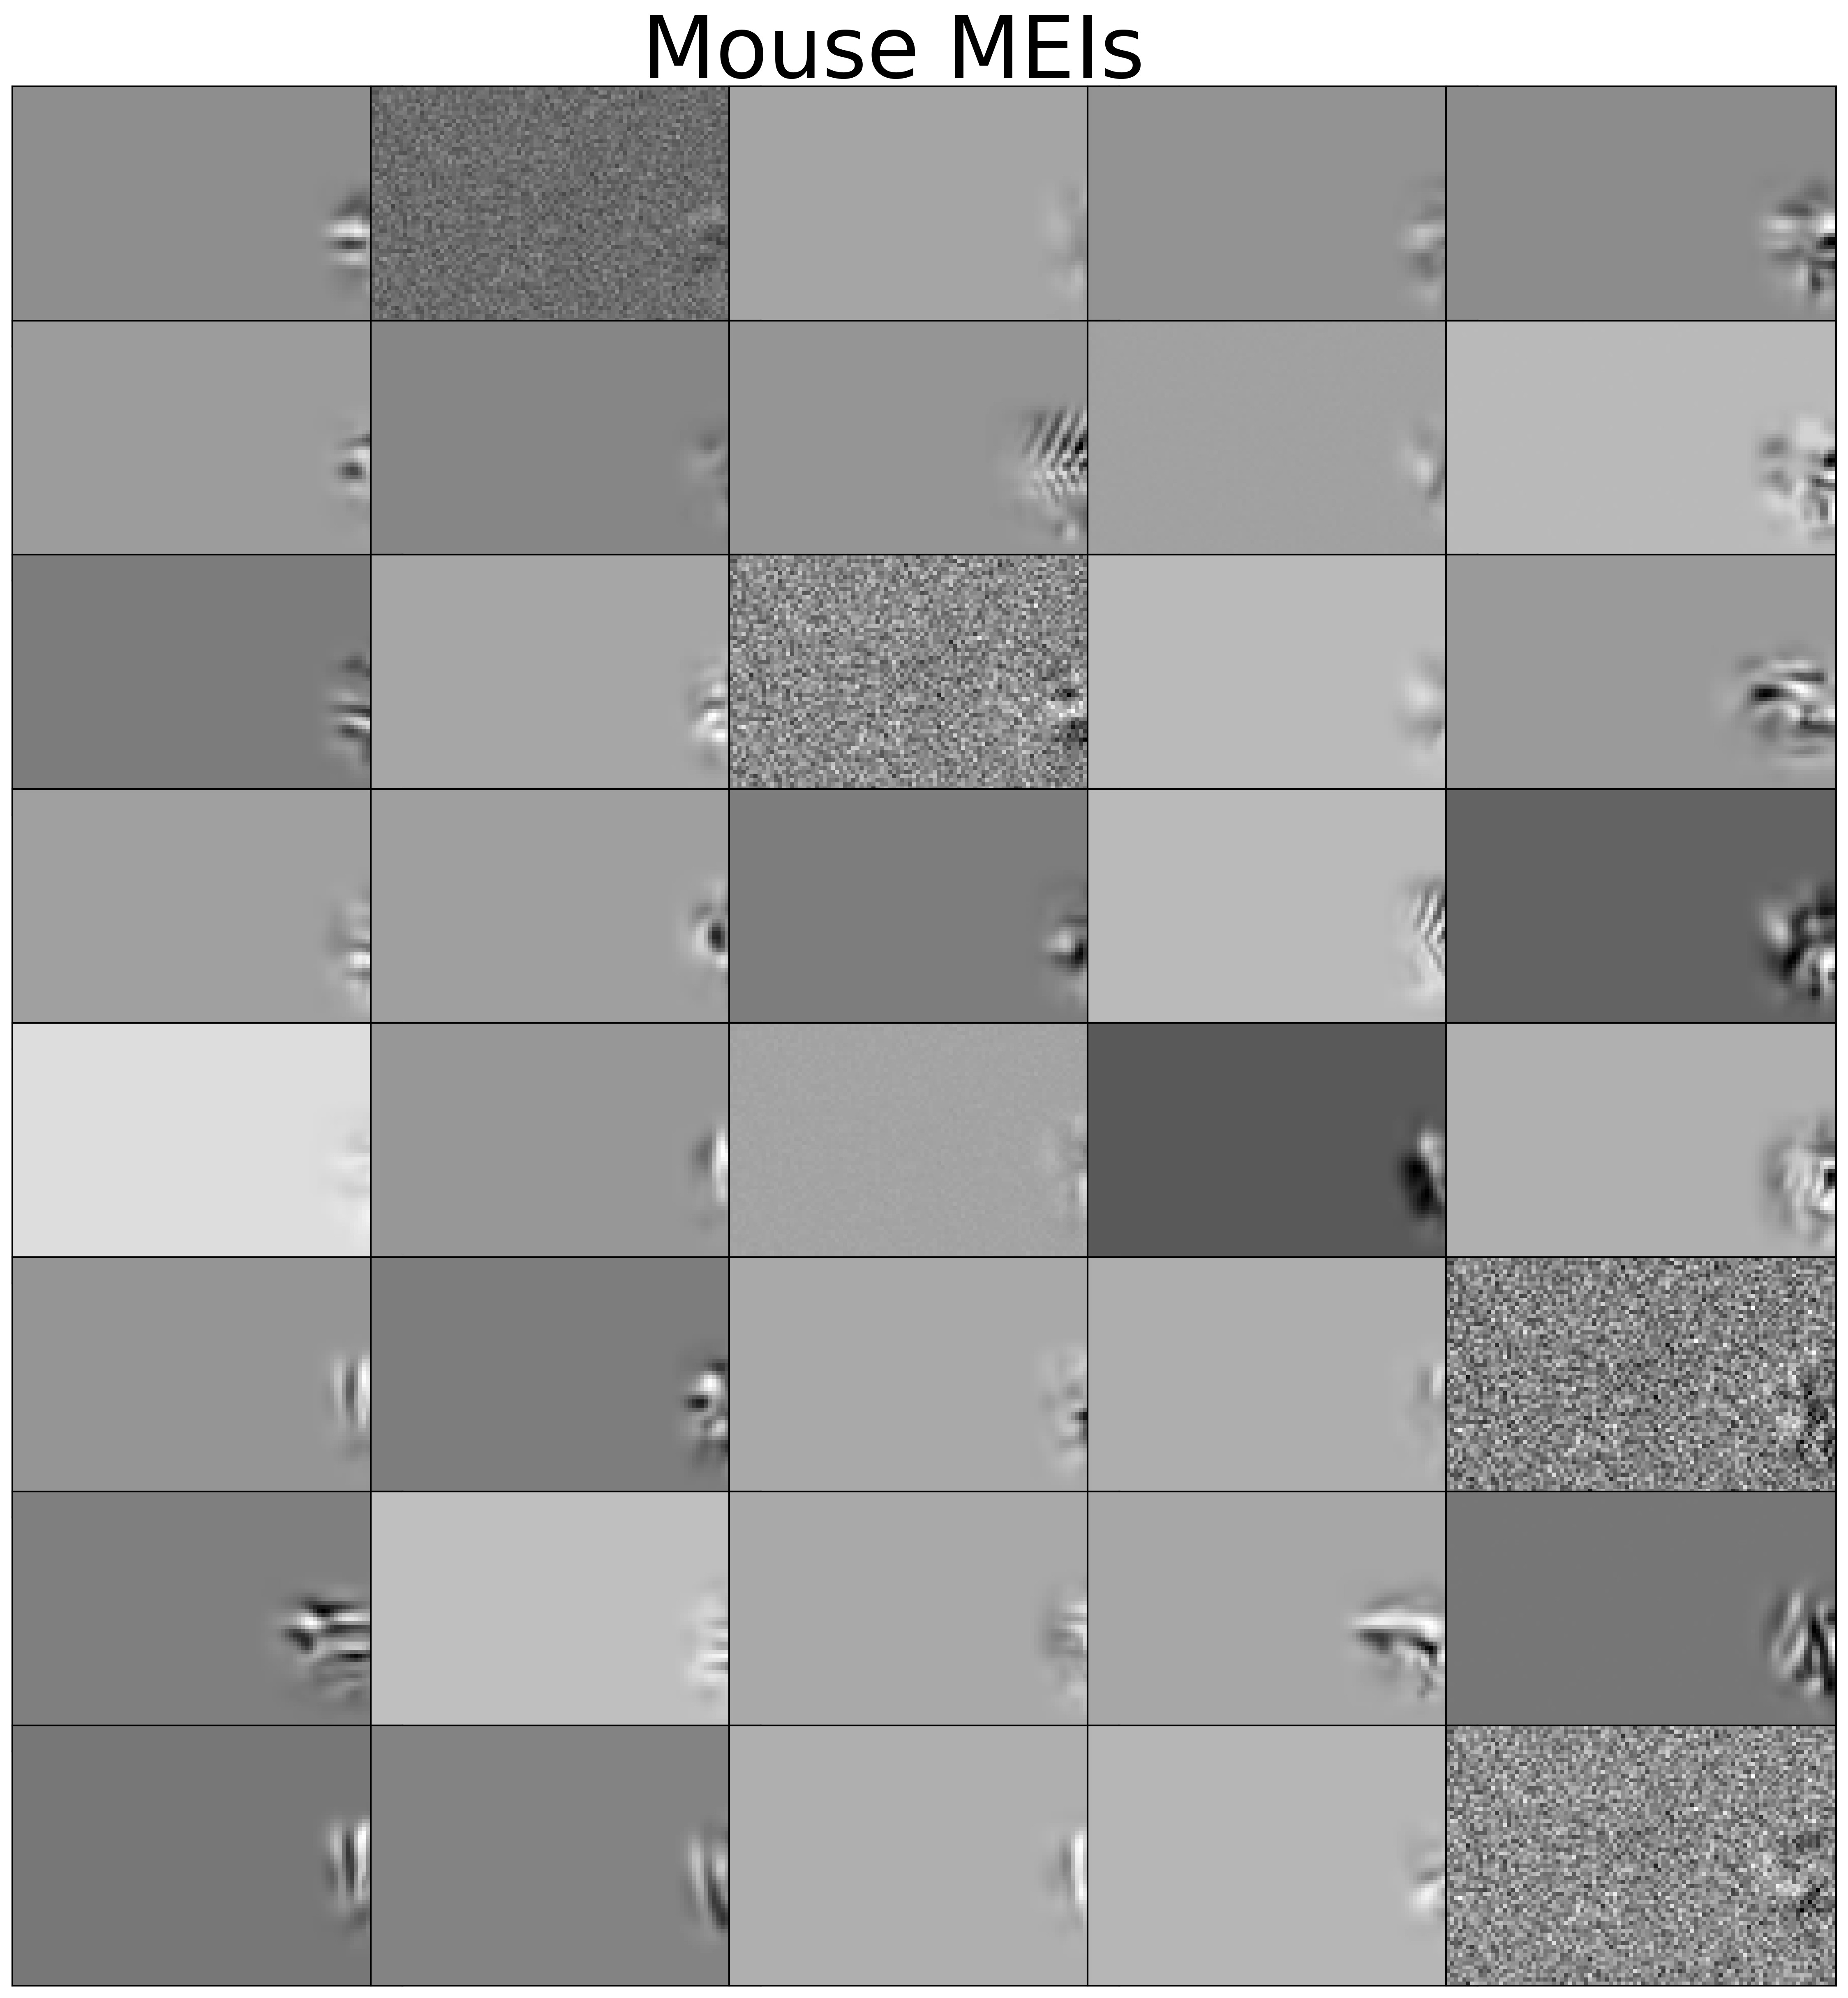

In [64]:
fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].imshow(meis[index].reshape(4, 64, 96).mean(0), cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
os.makedirs("Plots", exist_ok=True)
plt.savefig("Plots/MouseMEIsTop200.png", dpi=300)
plt.show()

In [65]:
# for k in range(4):
#     fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
#     fig.suptitle(f"Mouse MEIs Channel {k}", y=0.91, fontsize=50)
#     for i in tqdm(range(20)):
#         for j in range(10):
#             index = i * 10 + j
#             axes[i, j].imshow(meis[index].reshape(4, 64, 96)[k, :, :], cmap="gray")#, vmin=-1, vmax=1)
#             axes[i, j].spines['top'].set_color('black')
#             axes[i, j].spines['bottom'].set_color('black')
#             axes[i, j].spines['left'].set_color('black')
#             axes[i, j].spines['right'].set_color('black')
#             axes[i, j].spines['top'].set_linewidth(1)
#             axes[i, j].spines['bottom'].set_linewidth(1)
#             axes[i, j].spines['left'].set_linewidth(1)
#             axes[i, j].spines['right'].set_linewidth(1)
#             axes[i, j].set_xticks([])
#             axes[i, j].set_yticks([])
#     plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
#     os.makedirs("Plots", exist_ok=True)
#     plt.savefig(f"Plots/MouseMEIsTop200Channel{k}.png", dpi=300)
#     plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

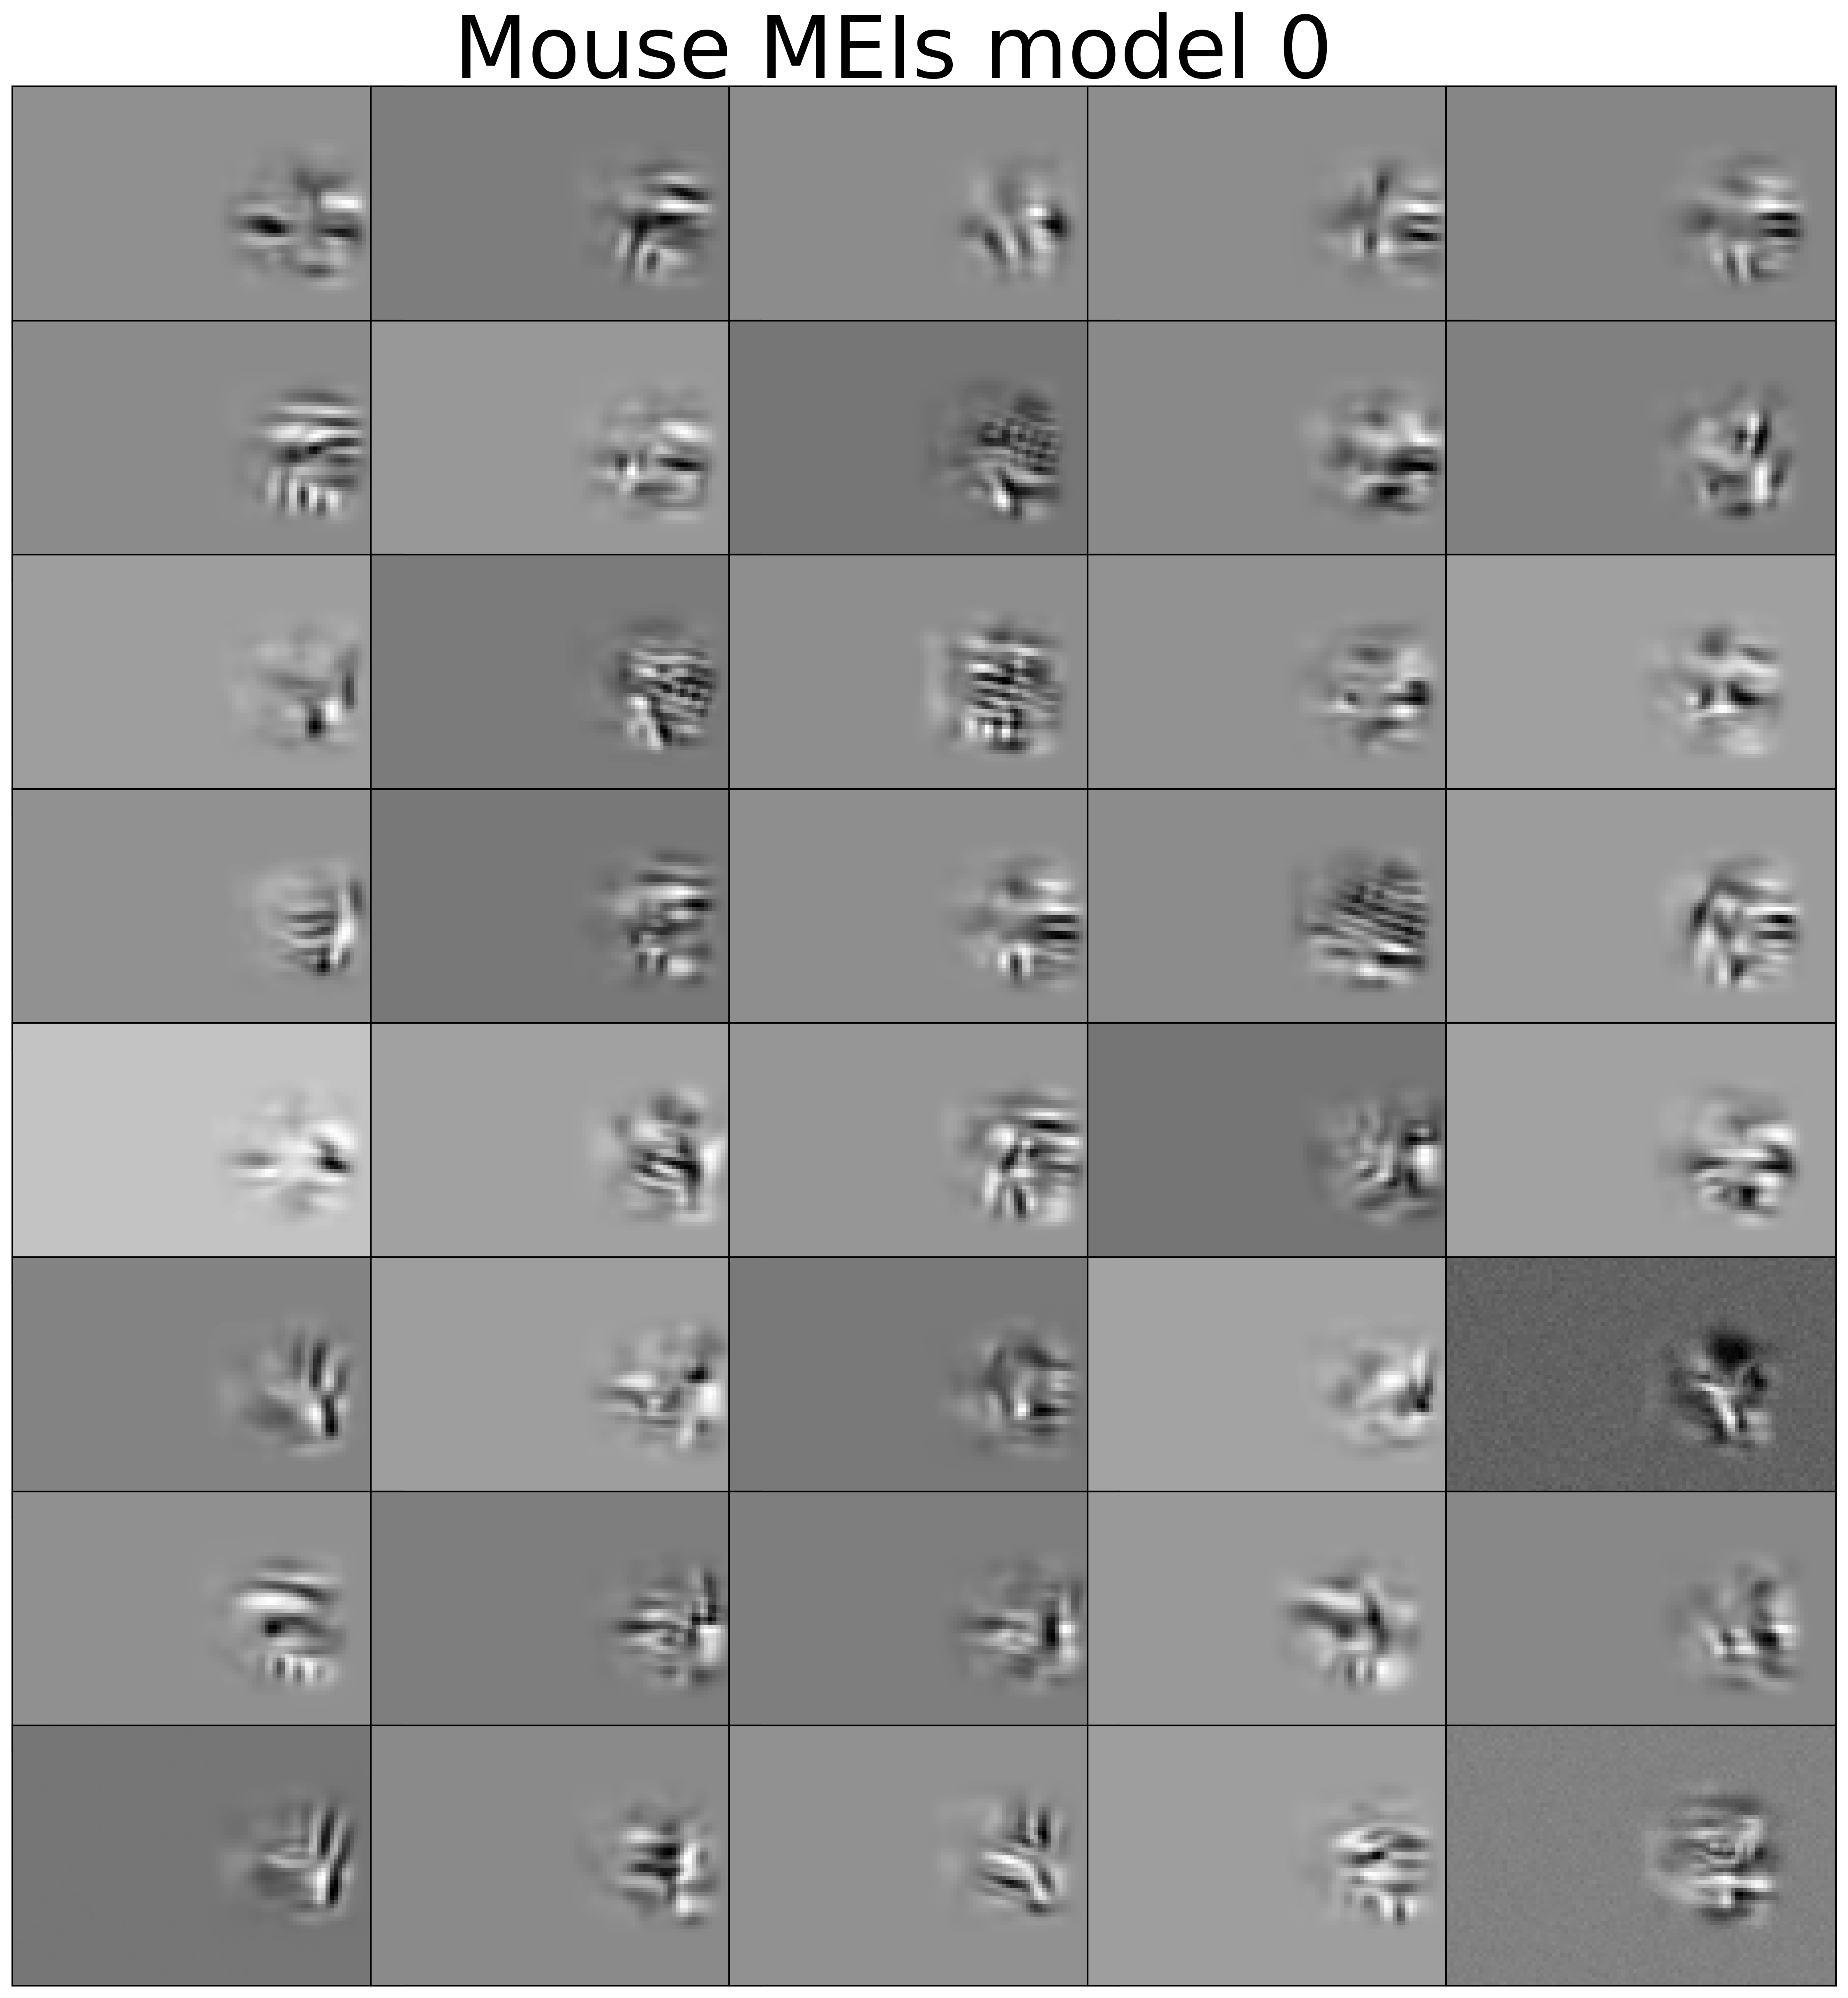

  0%|          | 0/8 [00:00<?, ?it/s]

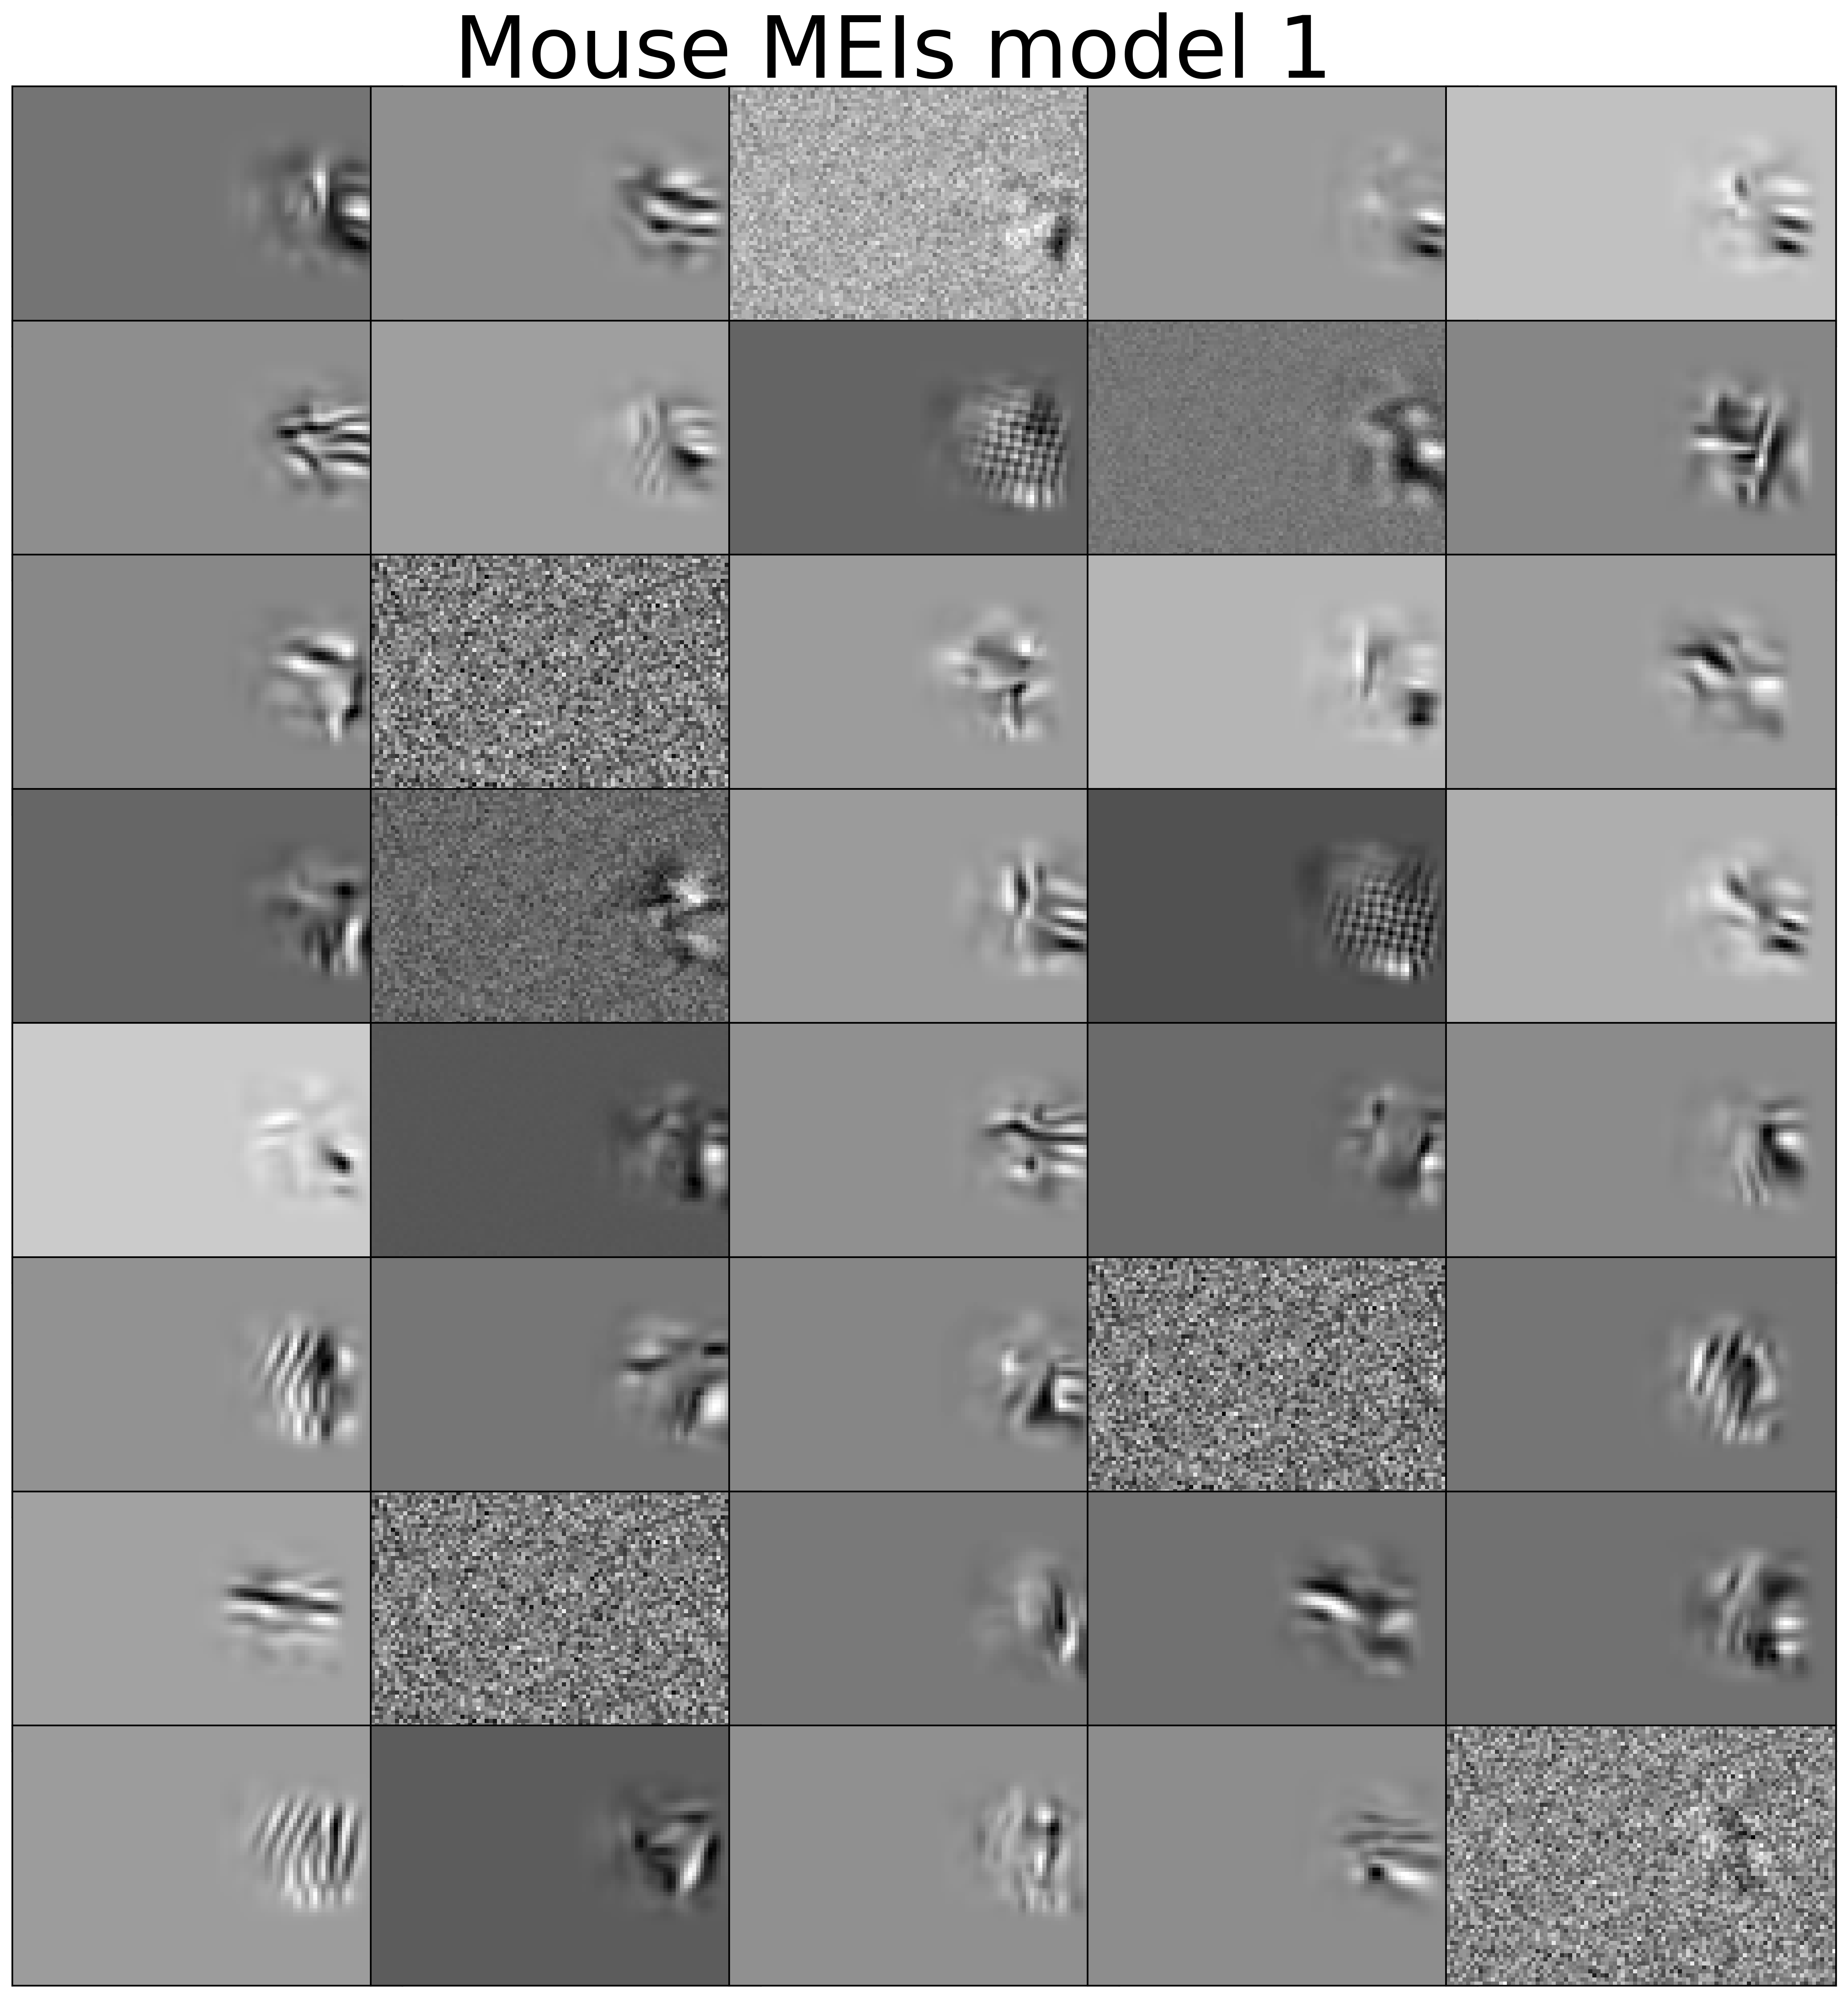

  0%|          | 0/8 [00:00<?, ?it/s]

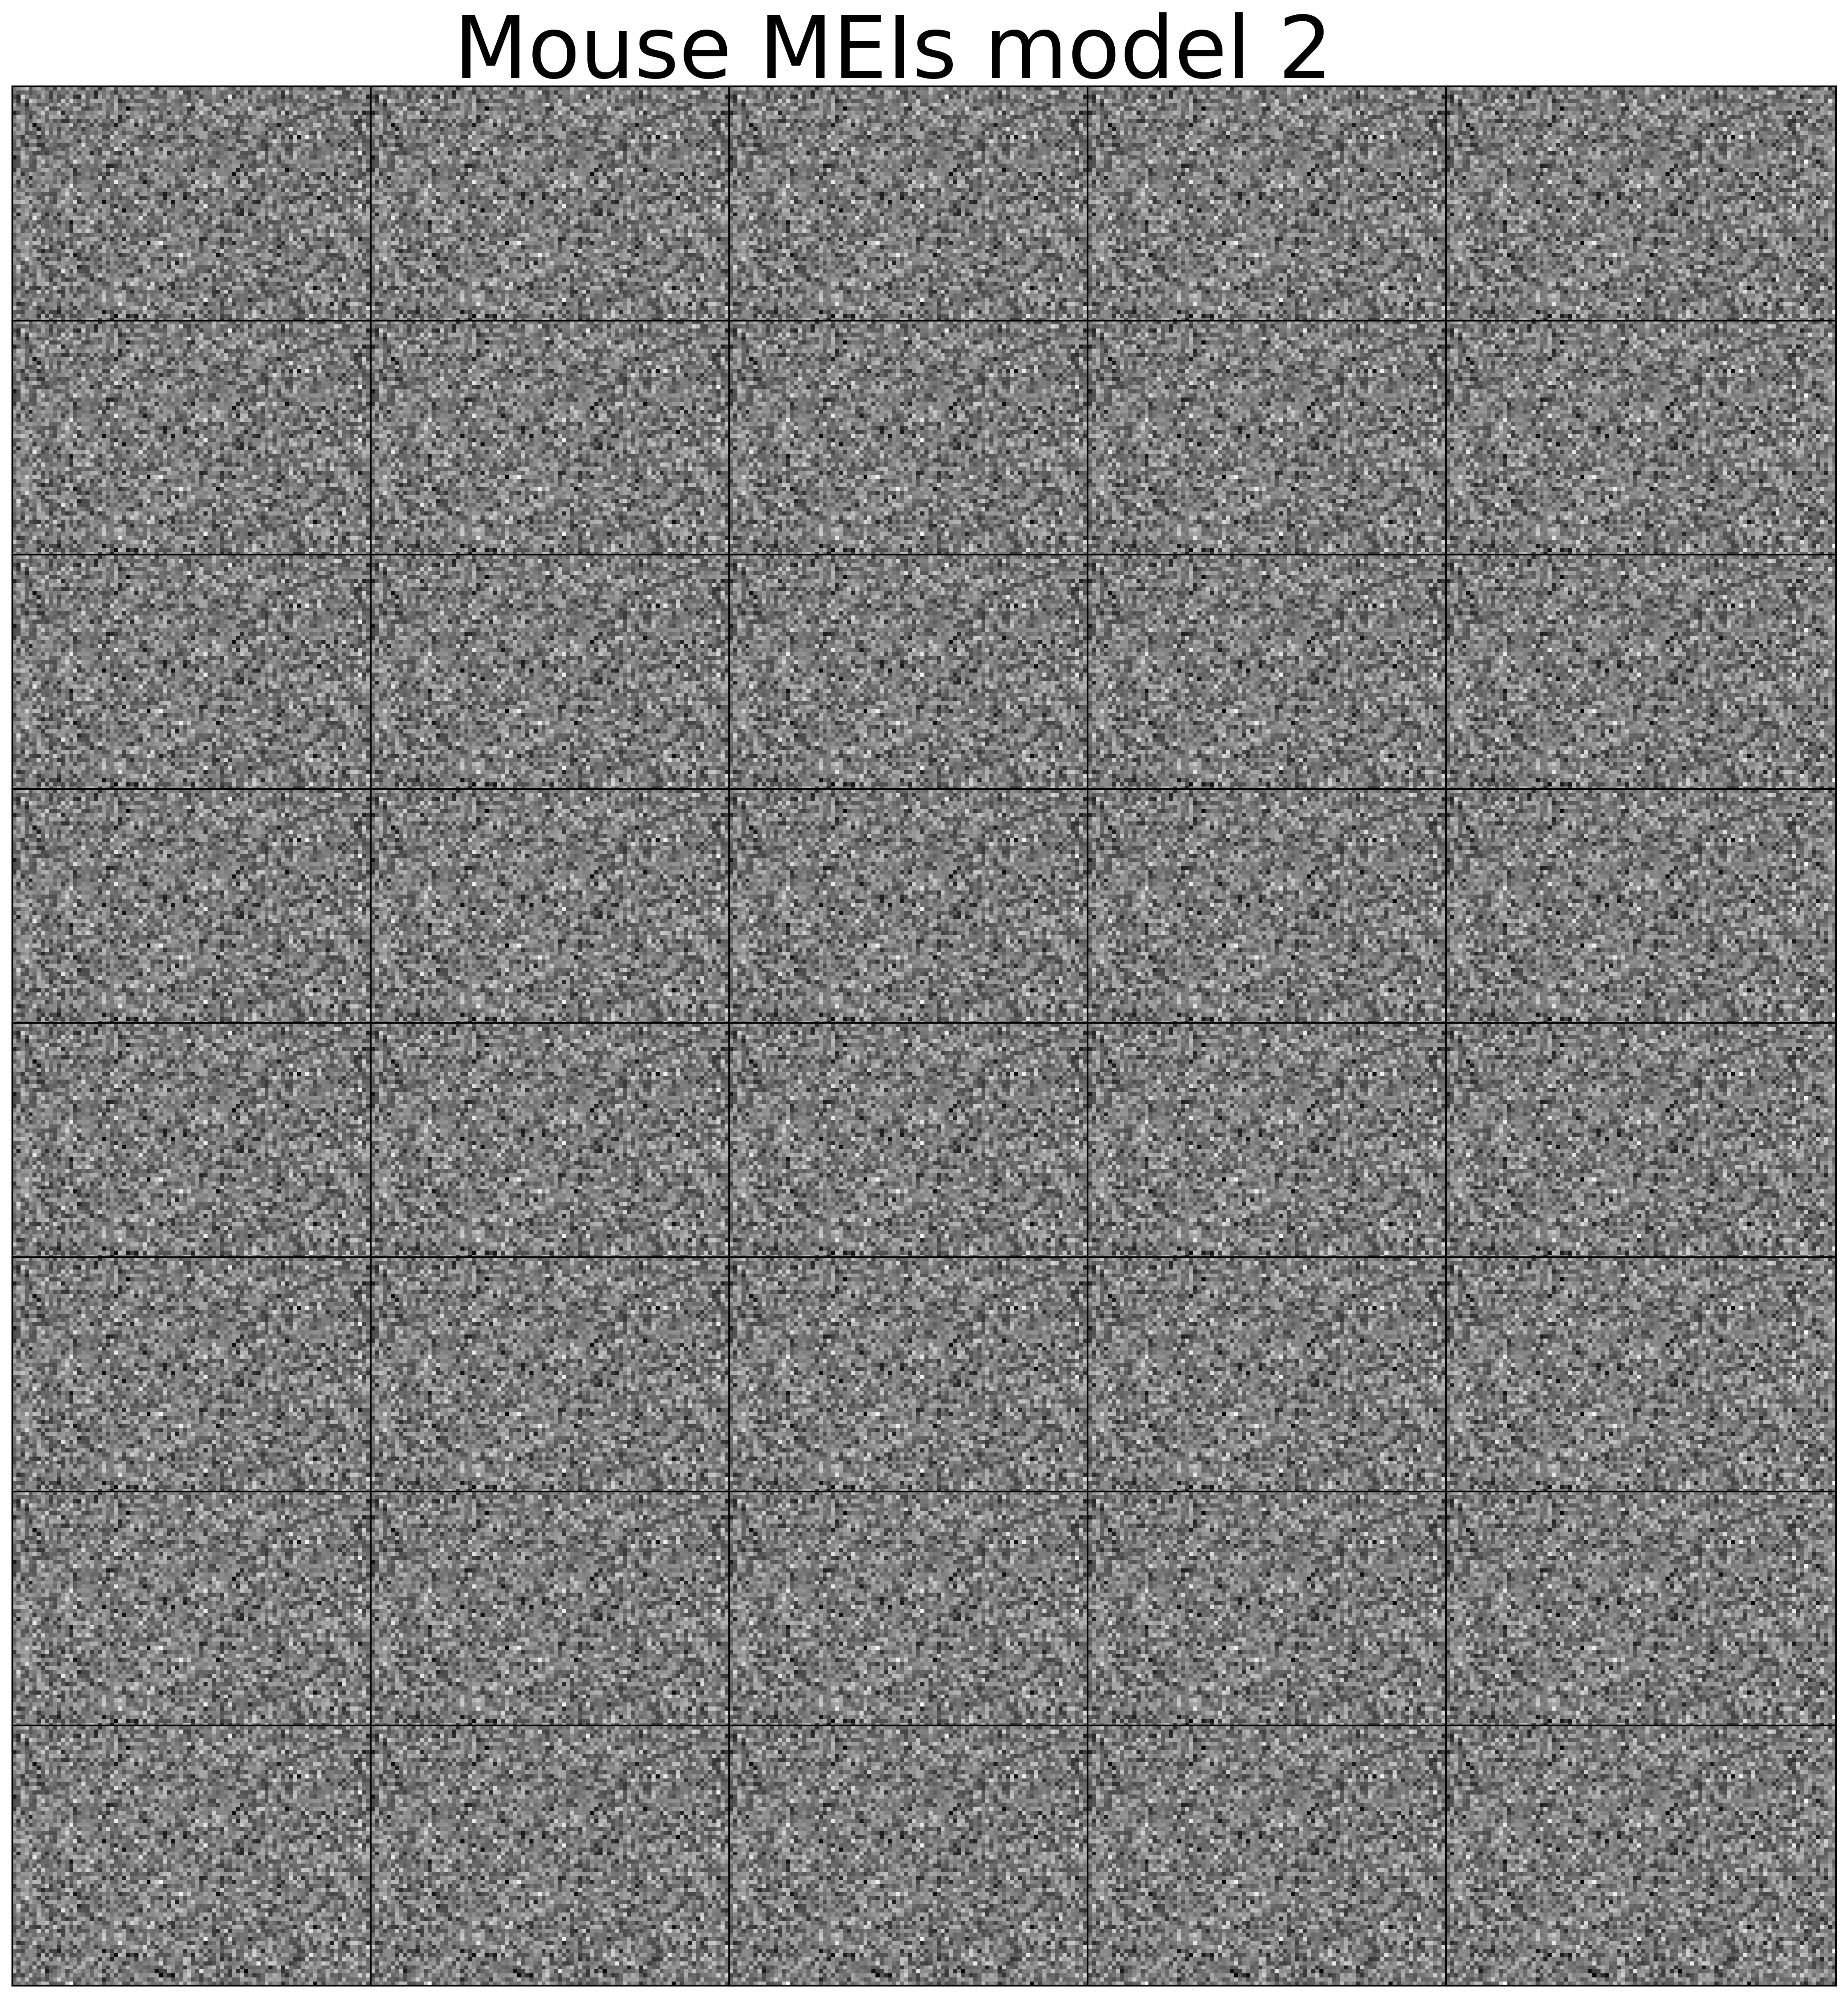

  0%|          | 0/8 [00:00<?, ?it/s]

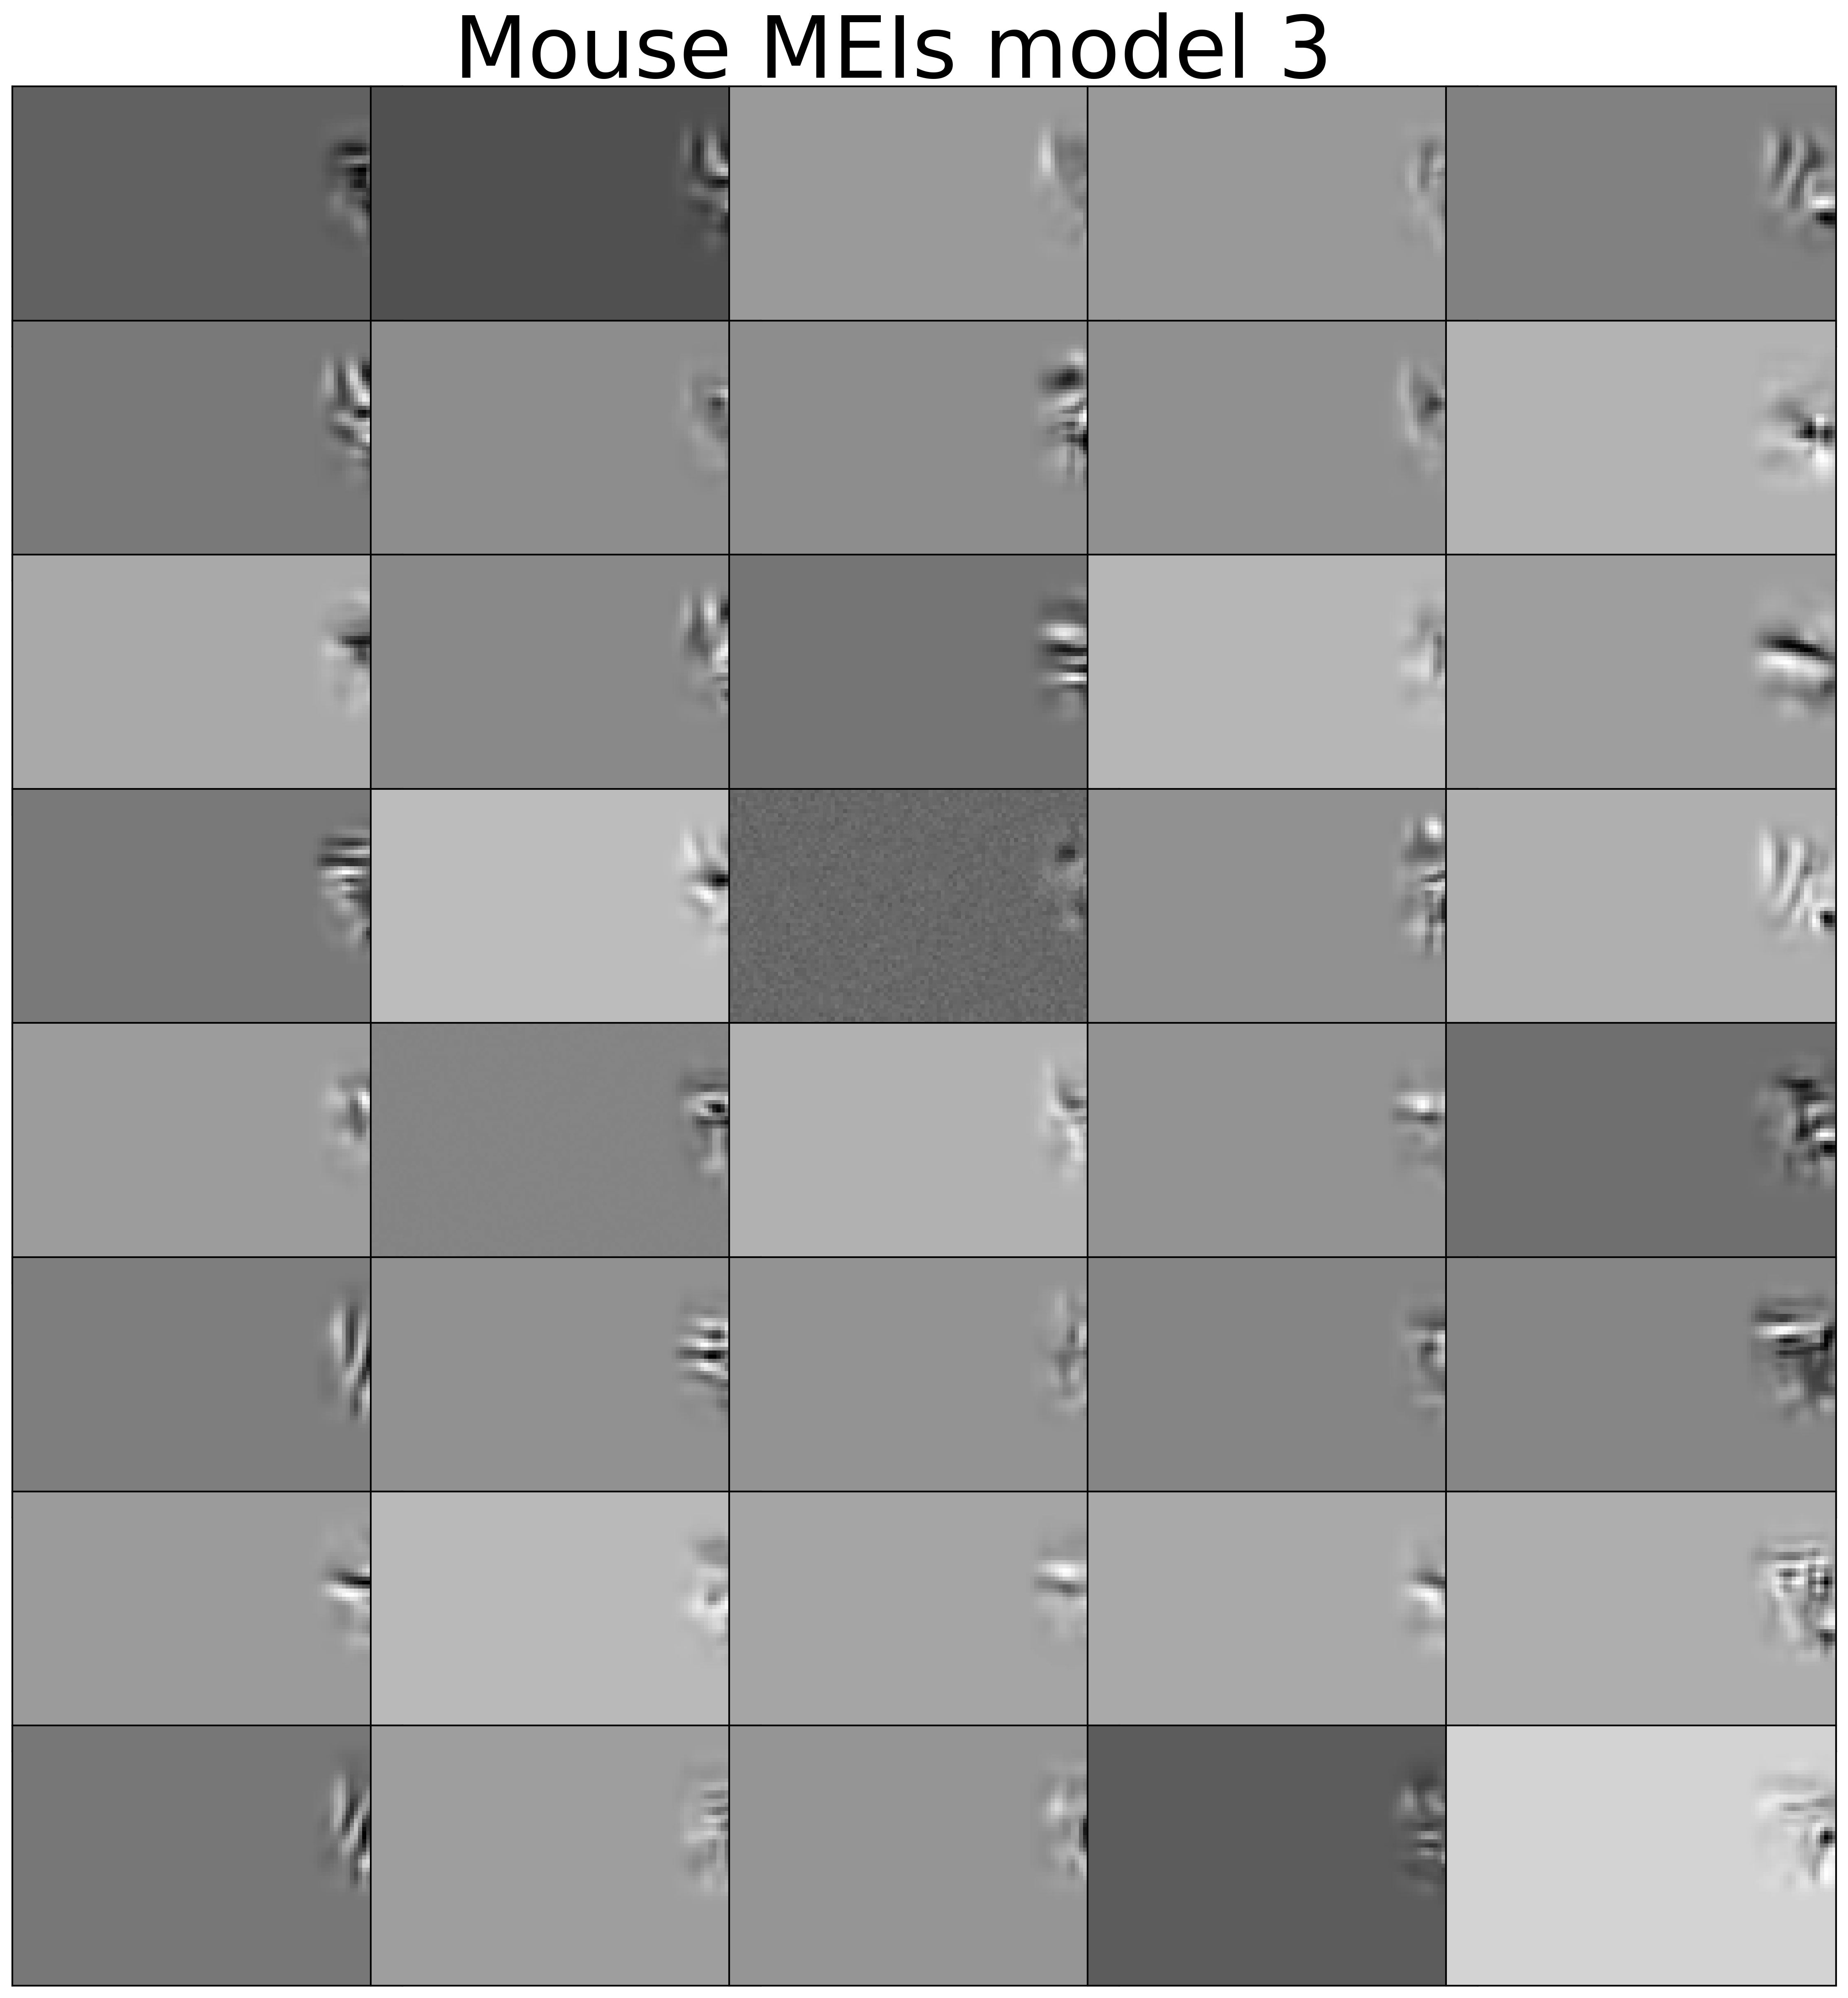

  0%|          | 0/8 [00:00<?, ?it/s]

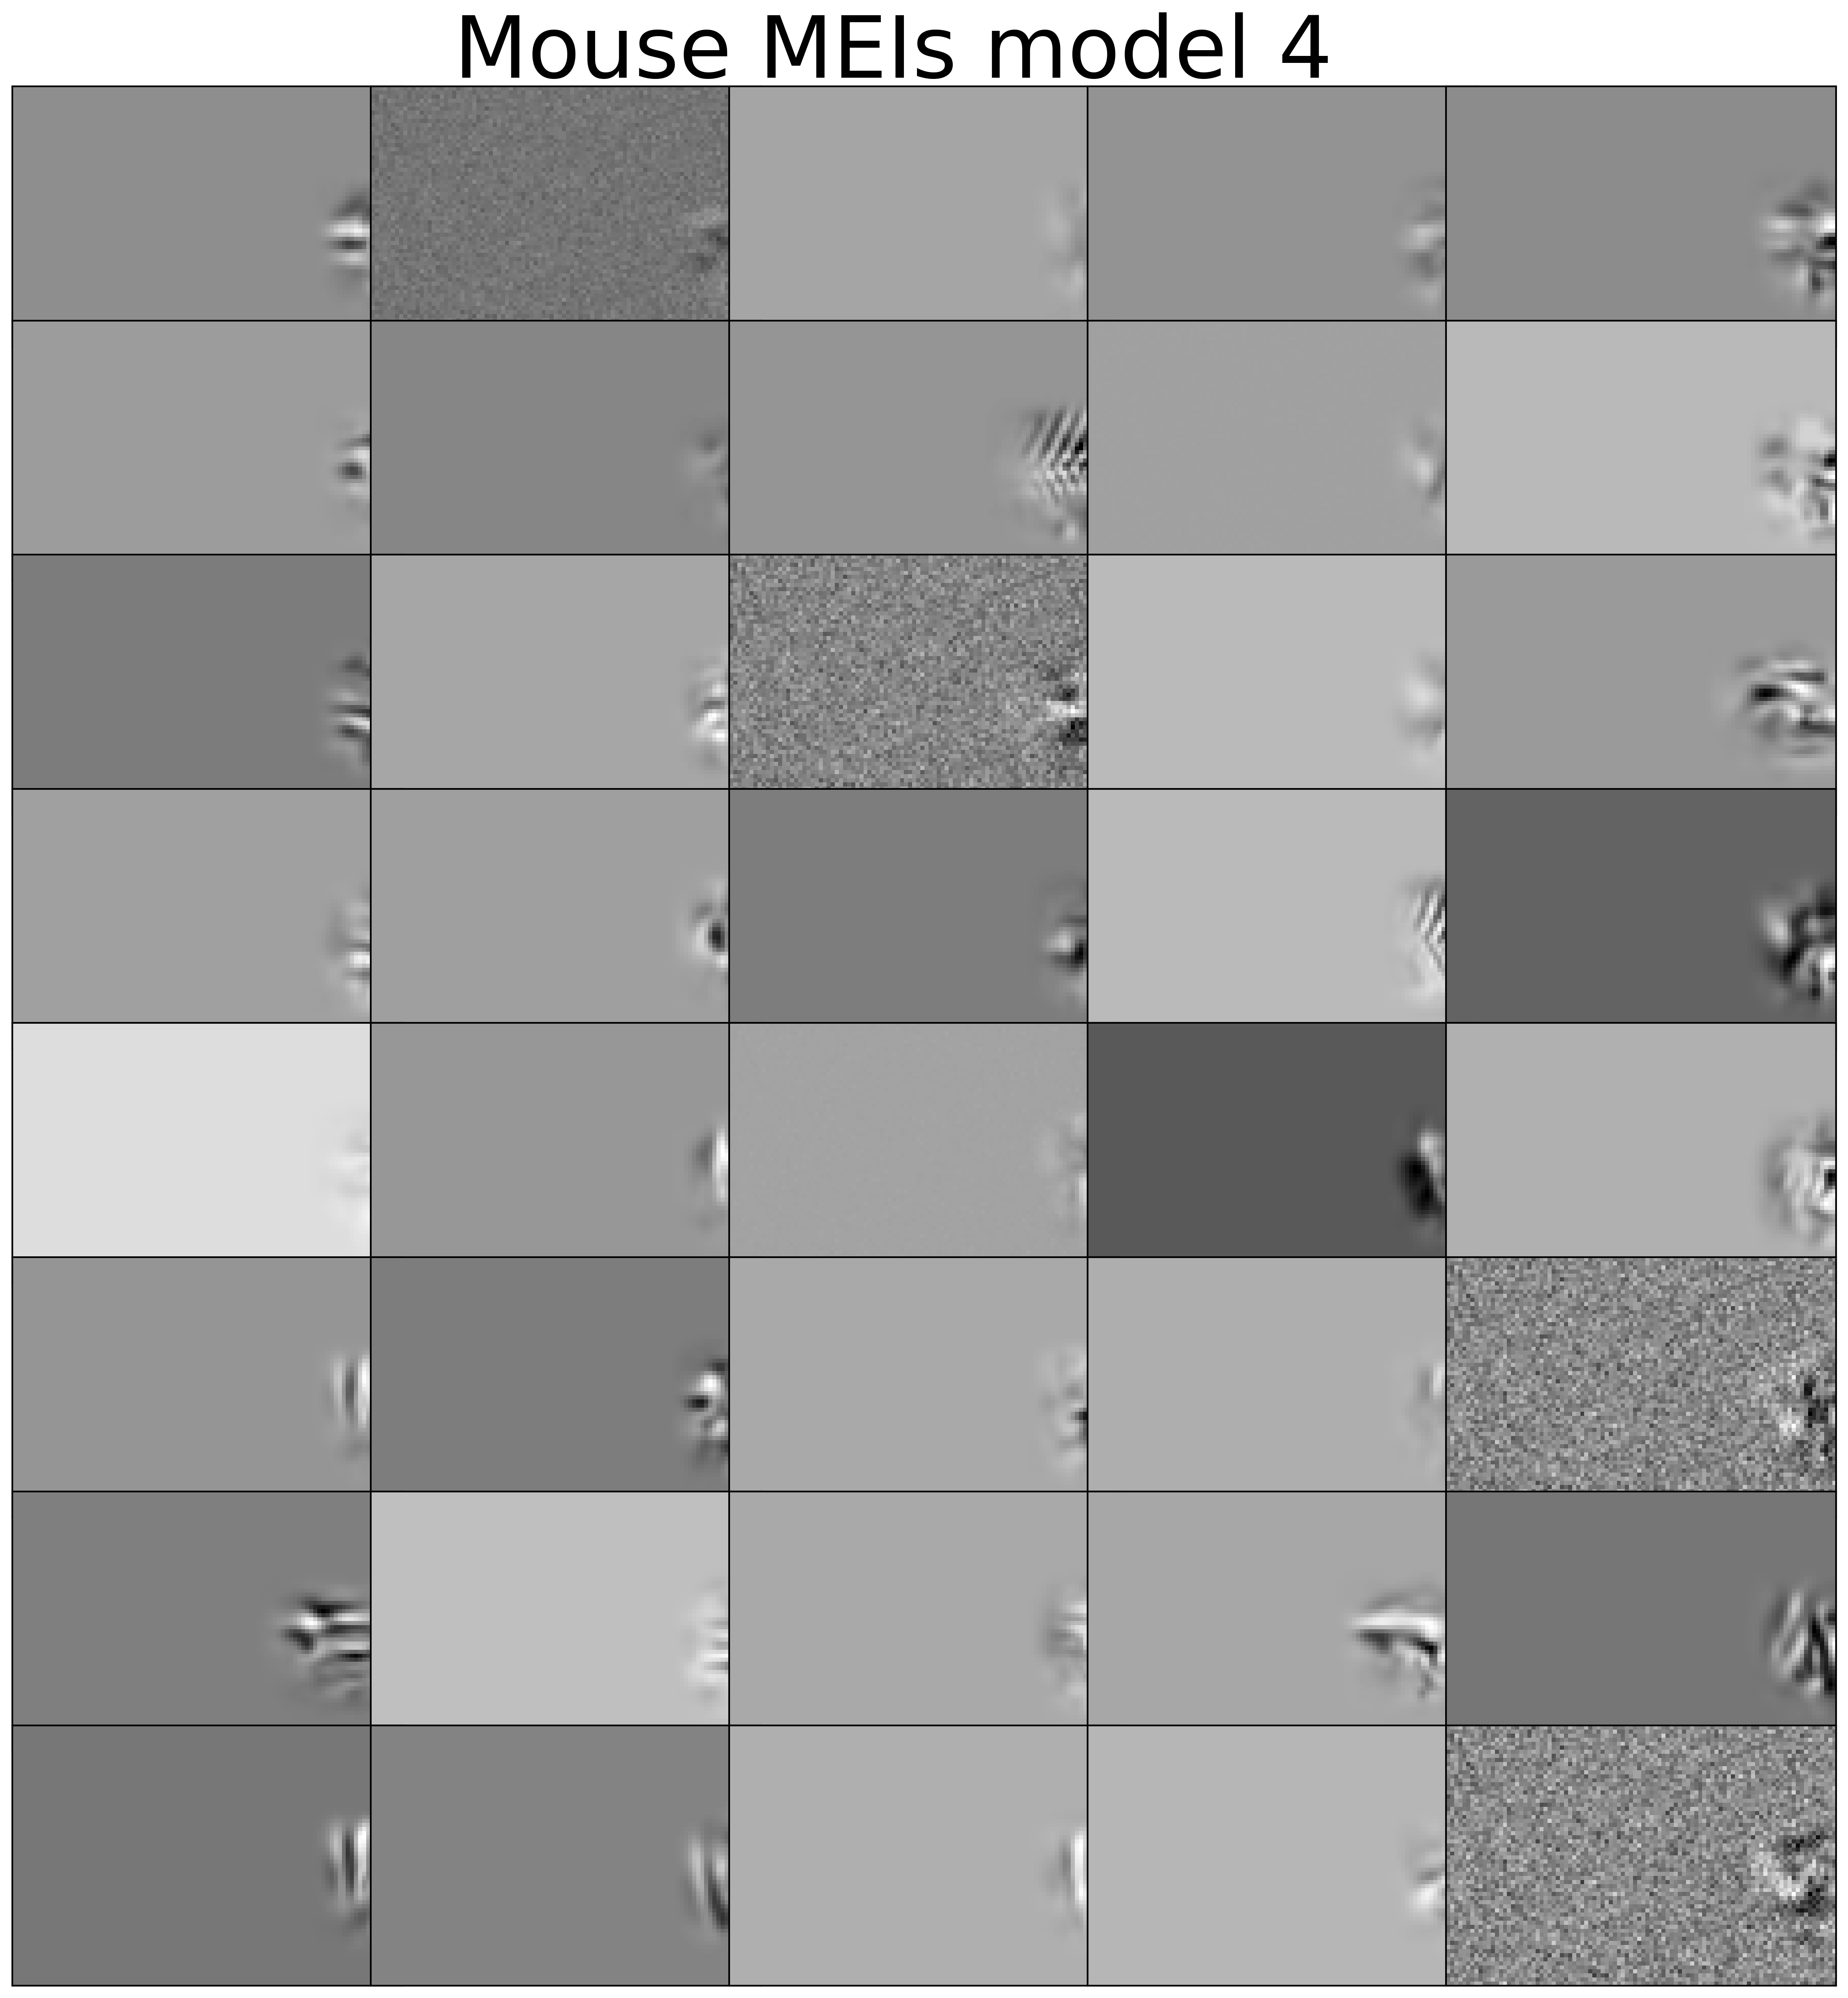

In [66]:
for k in range(5):
    meis = torch.load(f"MEIs/meis_model_{k}.pth")
    fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
    fig.suptitle(f"Mouse MEIs model {k}", y=0.91, fontsize=50)
    for i in tqdm(range(8)):
        for j in range(5):
            index = i * 5 + j
            axes[i, j].imshow(meis[index].reshape(4, 64, 96)[0, :, :], cmap="gray")#, vmin=-1, vmax=1)
            axes[i, j].spines['top'].set_color('black')
            axes[i, j].spines['bottom'].set_color('black')
            axes[i, j].spines['left'].set_color('black')
            axes[i, j].spines['right'].set_color('black')
            axes[i, j].spines['top'].set_linewidth(1)
            axes[i, j].spines['bottom'].set_linewidth(1)
            axes[i, j].spines['left'].set_linewidth(1)
            axes[i, j].spines['right'].set_linewidth(1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
    os.makedirs("Plots", exist_ok=True)
    plt.savefig(f"Plots/MouseMEIsTop200Model{k}.png", dpi=300)
    plt.show()

In [67]:
meis_list = []

for i in range(5):
    meis_list.append(torch.load(f"MEIs/meis_model_{i}.pth"))

meis_list = [torch.stack(meis, dim=0) for meis in meis_list]
meis_list = torch.stack(meis_list, dim=0)

avg_meis = meis_list.mean(dim=0)

  0%|          | 0/8 [00:00<?, ?it/s]

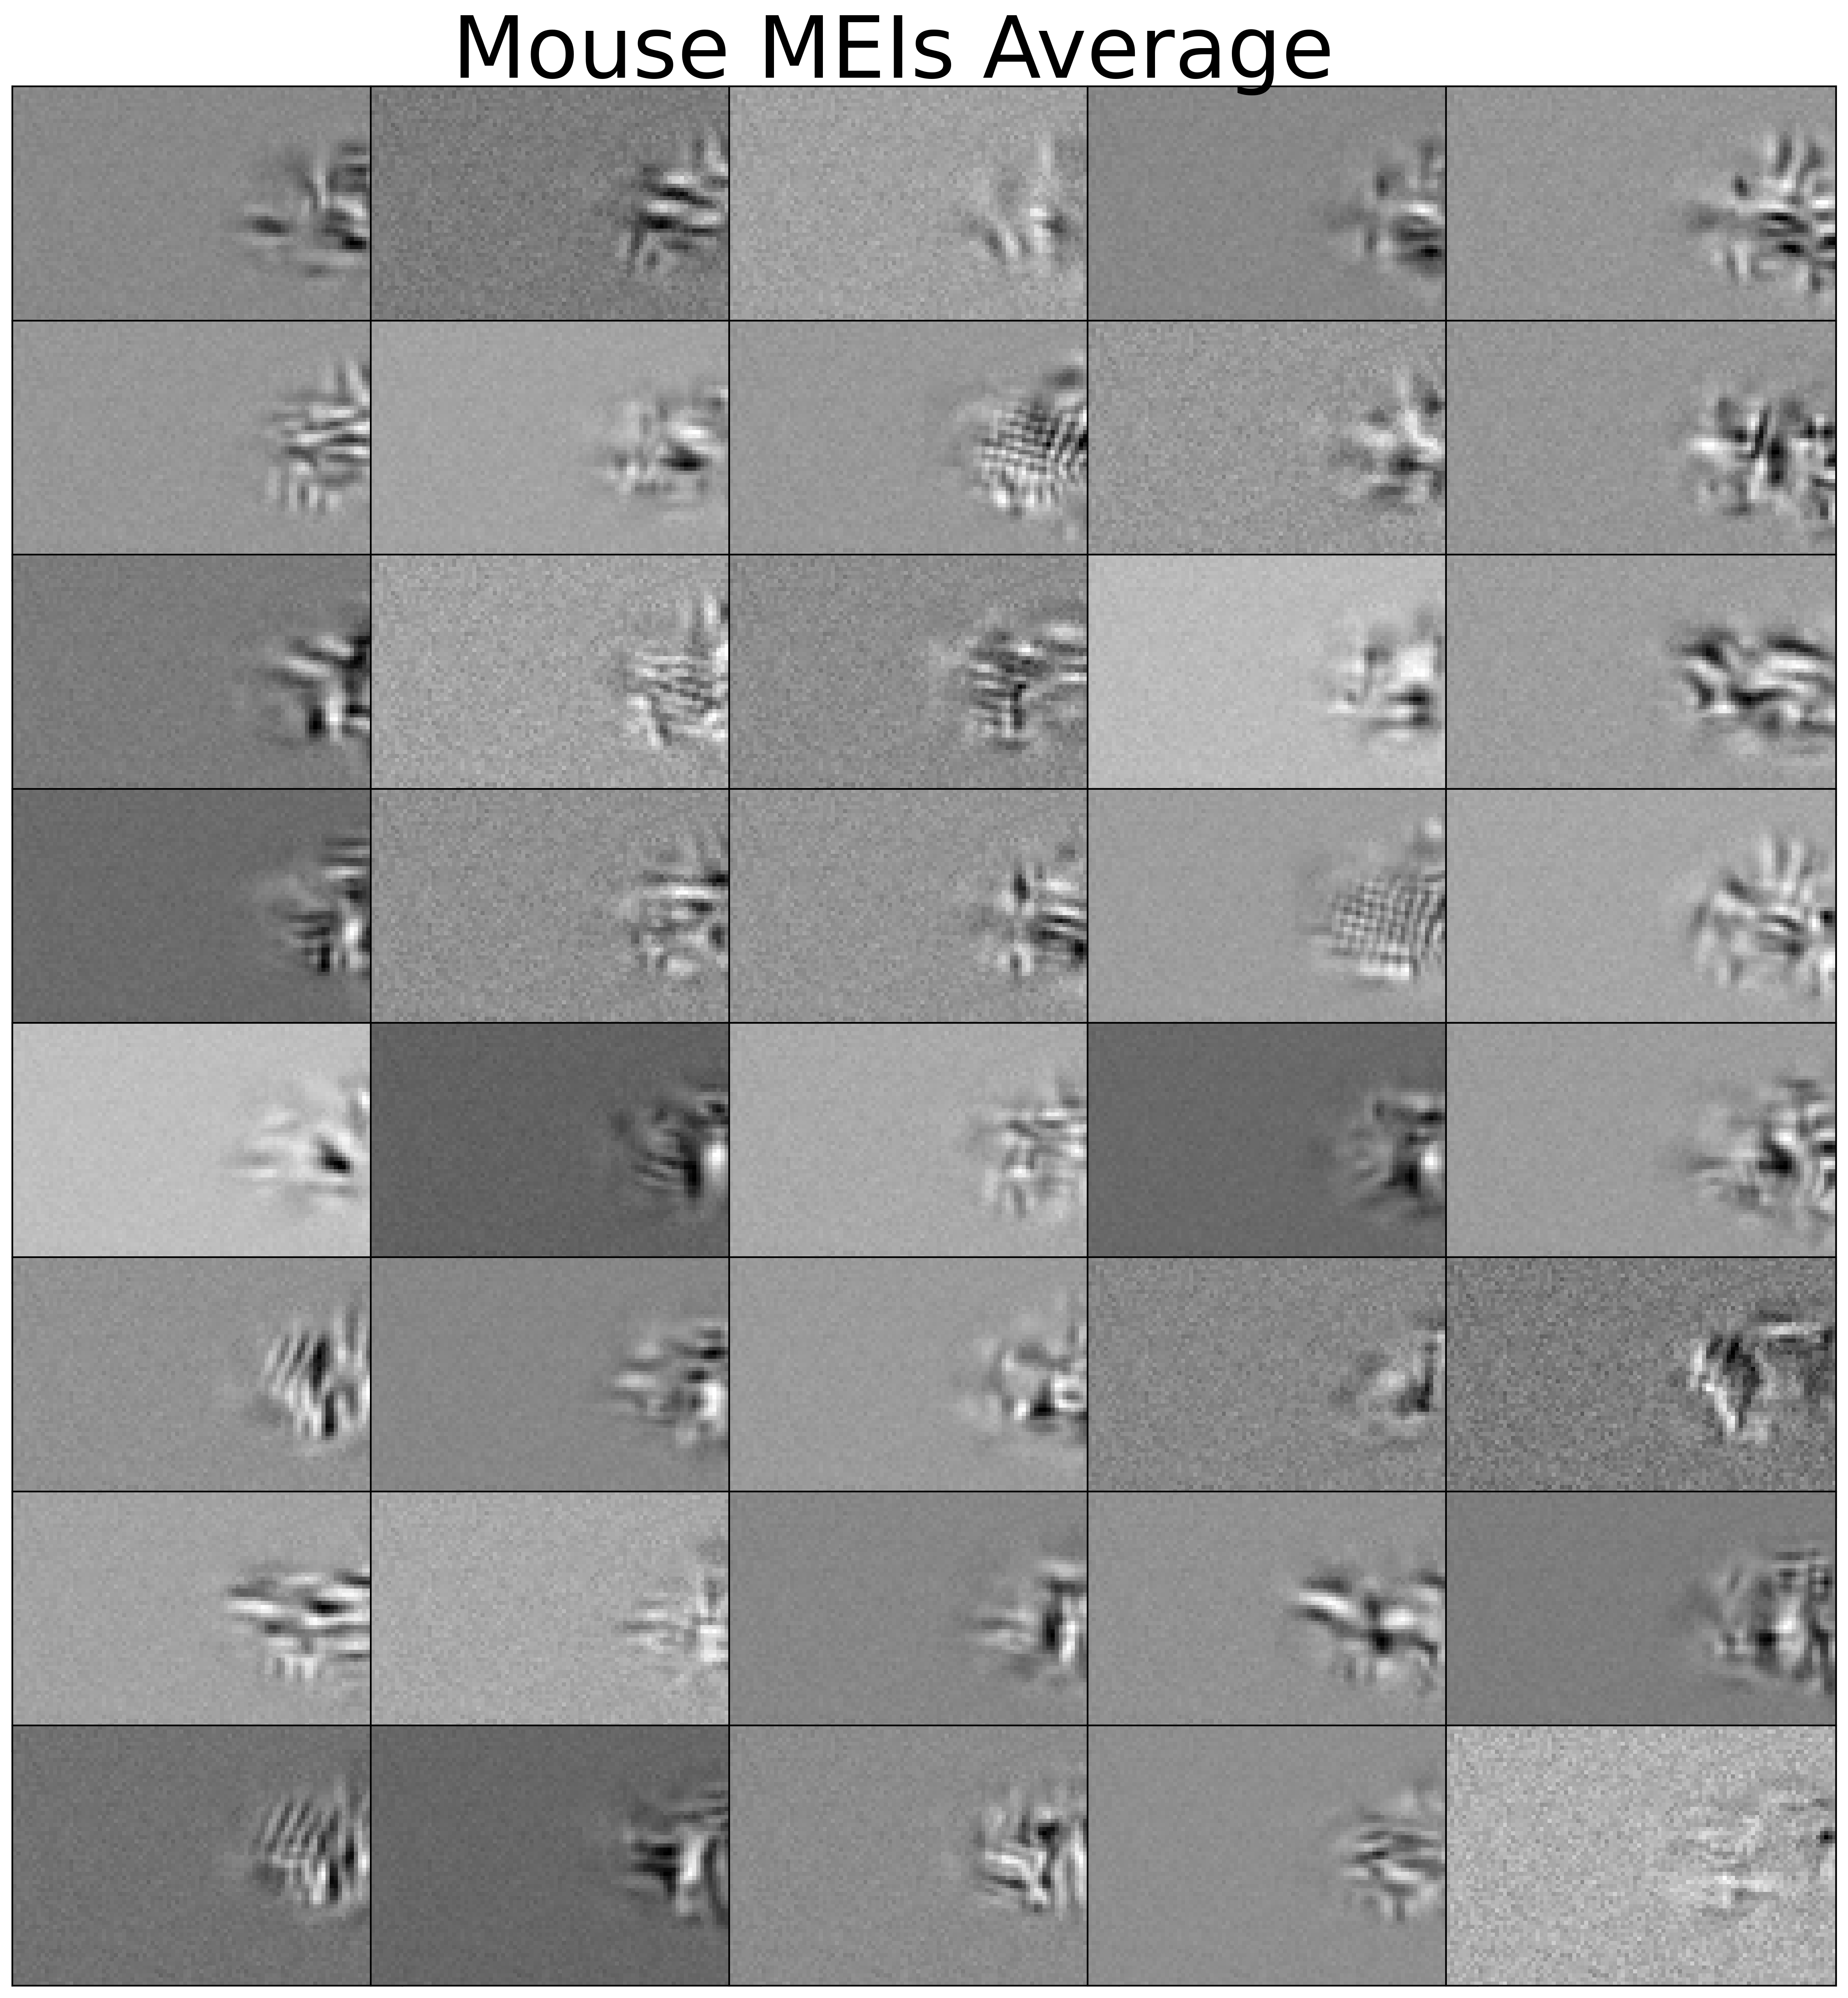

In [68]:
fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs Average", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].imshow(avg_meis[index][0, 0, :, :], cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
os.makedirs("Plots", exist_ok=True)
# plt.savefig("Plots/MouseMEIsTop200Average.png", dpi=300)
plt.show()

In [69]:
# fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
# fig.suptitle("Autistic Mouse", y=0.91, fontsize=50)
# for i in tqdm(range(20)):
#     for j in range(10):
#         index = i * 10 + j
#         axes[i, j].imshow(meis_a[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
#         axes[i, j].spines['top'].set_color('black')
#         axes[i, j].spines['bottom'].set_color('black')
#         axes[i, j].spines['left'].set_color('black')
#         axes[i, j].spines['right'].set_color('black')
#         axes[i, j].spines['top'].set_linewidth(1)
#         axes[i, j].spines['bottom'].set_linewidth(1)
#         axes[i, j].spines['left'].set_linewidth(1)
#         axes[i, j].spines['right'].set_linewidth(1)
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
# plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# plt.savefig("Plots/AutisticMouseMEIsTop200.png", dpi=300)

In [70]:
# fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
# plt.suptitle("Wild-type Mouse", y=0.91, fontsize=50)
# for i in range(20):
#     for j in range(10):
#         index = i * 10 + j
#         axes[i, j].imshow(meis_wt[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
#         axes[i, j].spines['top'].set_color('black')
#         axes[i, j].spines['bottom'].set_color('black')
#         axes[i, j].spines['left'].set_color('black')
#         axes[i, j].spines['right'].set_color('black')
#         axes[i, j].spines['top'].set_linewidth(1)
#         axes[i, j].spines['bottom'].set_linewidth(1)
#         axes[i, j].spines['left'].set_linewidth(1)
#         axes[i, j].spines['right'].set_linewidth(1)
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
# plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# plt.savefig("Plots/WildtypeMouseMEIsTop200.png", dpi=300)